In [47]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import accuracy_score
from sktime.forecasting.model_selection import SlidingWindowSplitter
from pyod.models.mcd import MCD
from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

In [123]:
def find_dominant_value(array):
    unique, counts = np.unique(array, return_counts=True)
    count_dict = dict(zip(unique, counts))
    return 0 if count_dict.get(0, 0) > count_dict.get(1, 0) else 1

def sawtooth_signal(A, f, t):
    T = 1 / f
    return  A * (t / T - np.floor(t / T))

def square_signal(A, f, t):
    T = 1 / f
    return 0.5*A + 0.5 * A * np.where(np.sin(2 * np.pi * f * t) > 0, 1, -1)

def random_signal(A, f, t, window_size):
    signal = np.zeros(len(t))
    labels = np.zeros(len(t))
    num_windows = int(len(t) // window_size)
    for i in range(num_windows):
        start = i * window_size
        end = (i + 1) * window_size  
        if np.random.random() > 0.4:
            signal[start:end] = square_signal(A, f, t[start:end]) + np.random.normal(0,0.01,len( t[start:end]))
            labels[start:end] = 0
        else:
            signal[start:end] = square_signal(A, f, t[start:end]) + np.random.normal(0,0.1,len( t[start:end]))
            labels[start:end] = 1
    return signal,labels

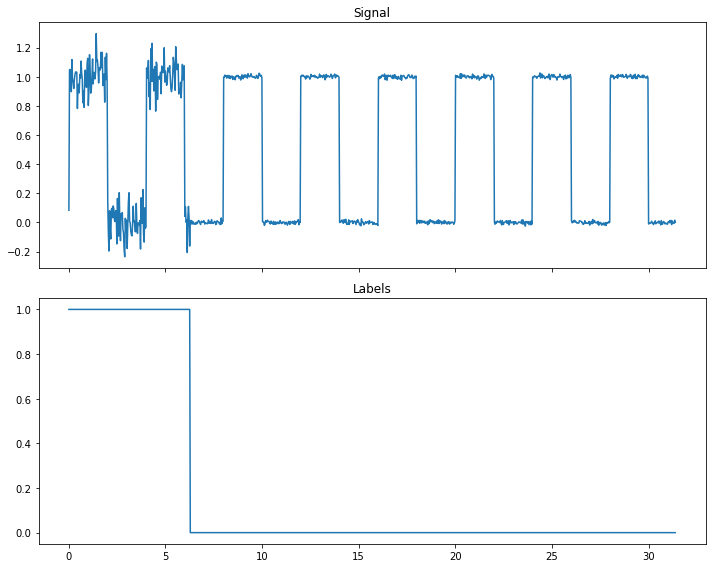

In [124]:
t = np.linspace(0, 800*np.pi, 80000)
s,l = random_signal(1, 0.25, t, 200)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axs[0].plot(t[0:1000], s[0:1000])
axs[0].set_title("Signal")
axs[1].plot(t[0:1000], l[0:1000])
axs[1].set_title("Labels")
plt.tight_layout()
plt.show()

In [125]:
winlen = 200
step = 200
splitter = SlidingWindowSplitter(window_length=winlen, step_length=step)

evlen = len(t)
#logger.info(f"event {evlen}")
S = splitter.split(np.arange(evlen))
Ns = splitter.get_n_splits(np.arange(evlen))
L = list(S)
X = np.zeros([Ns, 1, winlen])
Y = np.zeros([Ns])
for j in range(Ns):
    X[j,0,:] = s[L[j][0]]
    Y[j] = find_dominant_value(l[L[j][0]])

In [126]:
outliers_fraction = np.count_nonzero(Y) / len(Y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)

X_train =  X[0:250,0,:]
X_test =  X[250:299,0,:]
y_train = Y[0:250]
y_test = Y[250:299]

print(X_train.shape)
print(y_train.shape)
X_train_norm, X_test_norm = standardizer(X_train, X_test)



(250, 200)
(250,)


In [127]:
clf =  MCD(contamination=outliers_fraction, random_state=42)

clf.fit(X_train)
test_scores = clf.decision_function(X_test)



In [128]:
roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

print('{clf_name} ROC:{roc}, precision {prn}'.format(
            clf_name='MCD', roc=roc, prn=prn))


MCD ROC:0.9916, precision 0.9545
